# Задание 1
## Задача 1

In [2]:
import math

import numpy as np
from lab1.task1.golden_ratio import GoldenRatio
from lab1.task1.fibonacci import Fibonacci
from lab1.task1.dichotomy import Dichotomy
from lab1.watcher import Watcher
from lab1.task2.gradient_descent import GradientDescent
import matplotlib.pyplot as plt

Возьмем следующую унимодальную на отрезке [2.2, 2.8] функцию
$$f(x) = |\sin(x^2)|$$

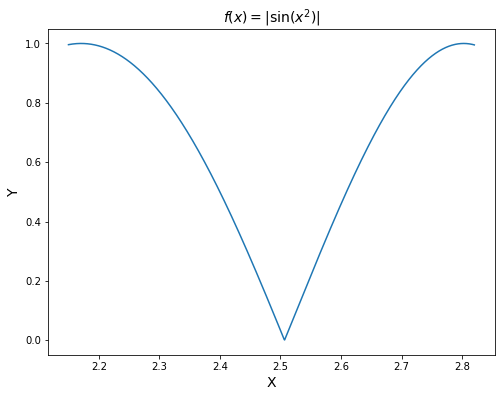

In [111]:
f = Watcher(lambda x: np.abs(np.sin(x ** 2)))
xs = np.linspace(2.15, 2.82, 1000)
ys = list(map(f, xs))
plt.figure(figsize=(8, 6))
plt.plot(xs, ys)
plt.xlabel("X", fontsize=14)
plt.ylabel("Y", fontsize=14)
plt.title("$f(x) = |\sin(x^2)|$", fontsize=14)
plt.show()

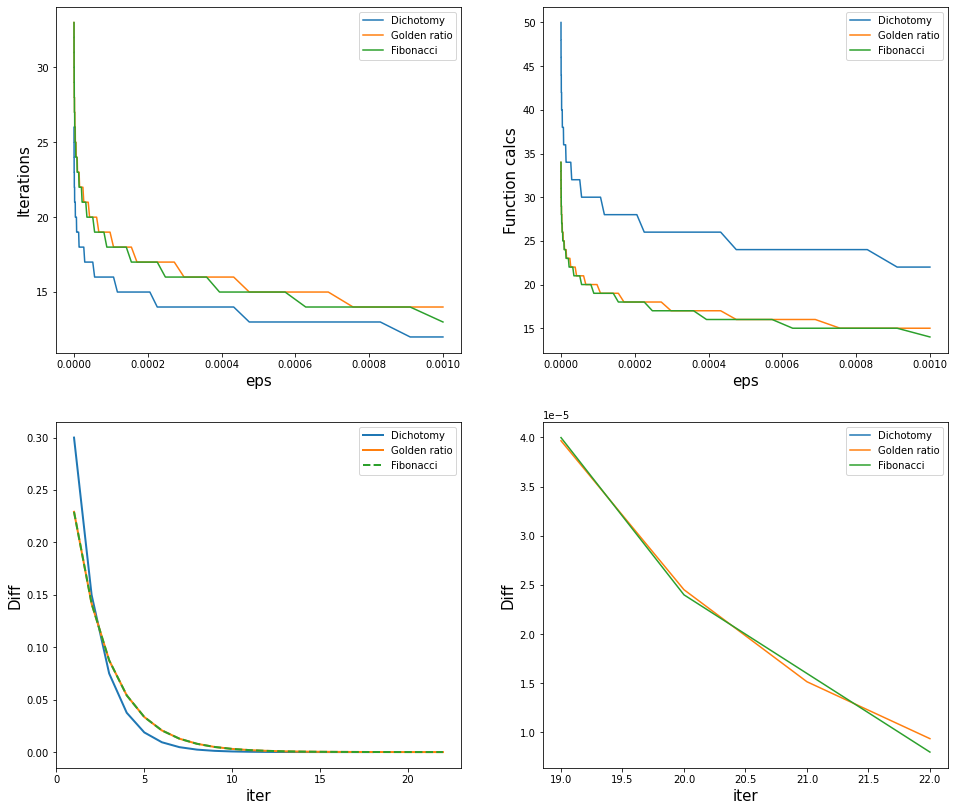

In [6]:
opts = [Dichotomy, GoldenRatio, Fibonacci]
fig = plt.figure(figsize=(16, 14))

# Eps/N
axn = fig.add_subplot(2, 2, 1)
axn.set_xlabel('eps', fontsize=15)
axn.set_ylabel('Iterations', fontsize=15)

# Eps/Calc
axc = fig.add_subplot(2, 2, 2)
axc.set_xlabel('eps', fontsize=15)
axc.set_ylabel('Function calcs', fontsize=15)

for opt_c in opts:
    epss = np.logspace(-7, -3, 100)
    ns = []
    calcs = []
    for eps in epss:
        opt = opt_c(f, eps, [2.2, 2.8])
        opt.opt()
        ns.append(len(opt.log_frame()))
        calcs.append(f.invocations)
    axn.plot(epss, ns, label=opt_c.name)
    axc.plot(epss, calcs, label=opt_c.name)

axn.legend()
axc.legend()

# Next iteration
axd = fig.add_subplot(2, 2, 3)
axd.set_xlabel('iter', fontsize=15)
axd.set_ylabel('Diff', fontsize=15)

axd_sc = fig.add_subplot(2, 2, 4)
axd_sc.set_xlabel('iter', fontsize=15)
axd_sc.set_ylabel('Diff', fontsize=15)

for opt_c in opts:
    opt = opt_c(f, 10e-6, [2.2, 2.8])
    opt.opt()
    diffs = []
    prev = -1
    log = opt.log_frame()
    for i, row in log.iterrows():
        now = row['r'] - row['l']
        if i > 0:
            diffs.append(prev - now)
        prev = now
    if opt_c == Fibonacci:
        st = "--"
    else:
        st = "-"
    axd.plot(range(1, len(log)), diffs, label=opt_c.name, linestyle=st, linewidth=2)
    axd_sc.plot(range(1, len(log))[18:], diffs[18:], label=opt_c.name)

axd.legend()
axd_sc.legend()
plt.show()

## Задача 2

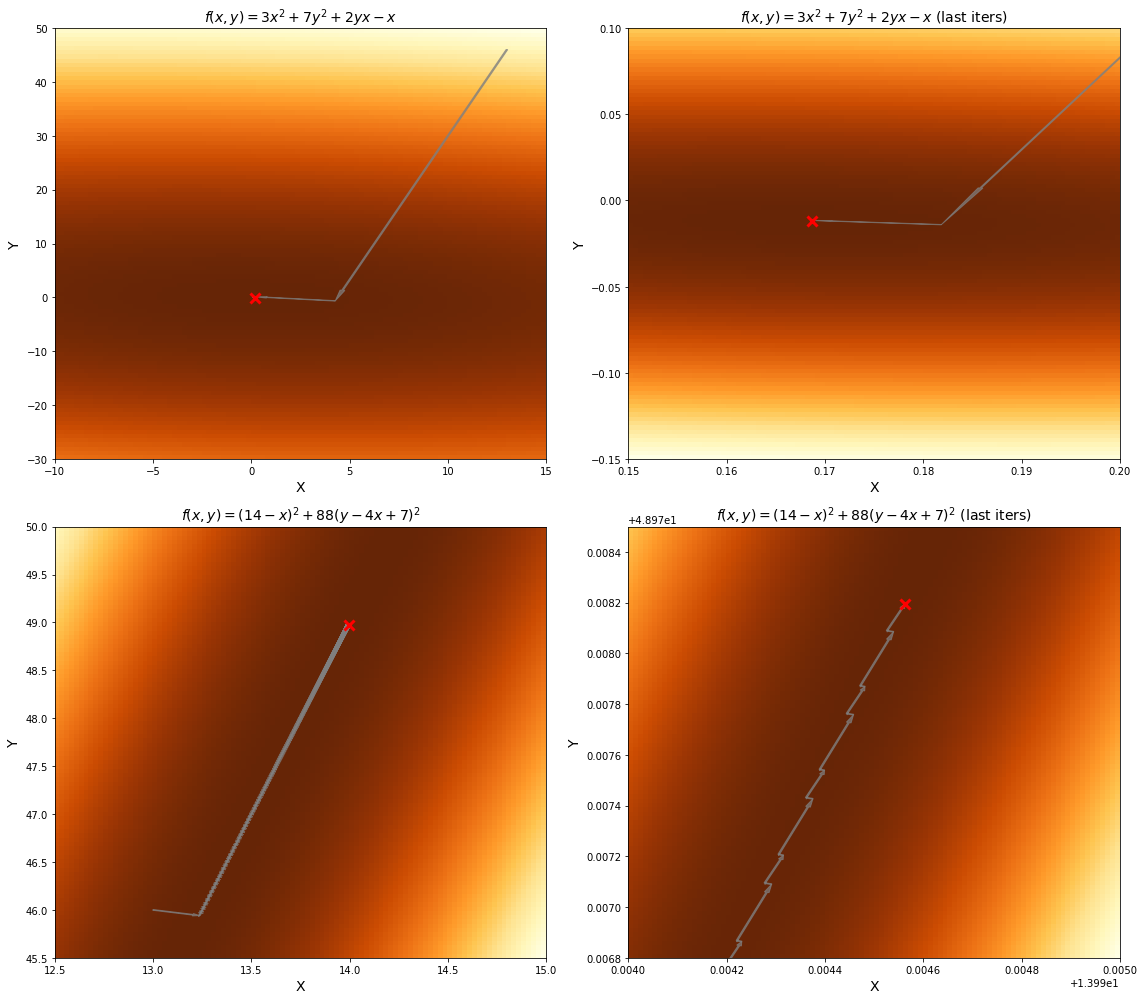

In [50]:
def plot_graph(ind, fig, opt, title, x_min, x_max, y_min, y_max):
    f = opt.f
    ax = fig.add_subplot(2, 2, ind)
    n_cnt = 100
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_xlabel('X', fontsize=14)
    ax.set_ylabel('Y', fontsize=14)
    ax.set_title(title, fontsize=14)
    log = opt.log_frame()
    colors = []
    for y in np.linspace(y_min, y_max, n_cnt):
        colors_l = []
        for x in np.linspace(x_min, x_max, n_cnt):
            colors_l.append(-f(x, y))
        colors.append(colors_l)

    x_step = (x_max - x_min) / n_cnt
    y_step = (y_max - y_min) / n_cnt
    xs, ys = np.meshgrid(np.arange(x_min, x_max + x_step / 2, x_step), np.arange(y_min, y_max + y_step / 2, y_step))

    ax.pcolormesh(xs, ys, colors, cmap='YlOrBr')

    ax.plot(mn[0], mn[1], 'x', color='red', ms=10, mew=3)

    last = None
    for ind, e in log.iterrows():
        if last is not None:
            dx = e['x'] - last[0]
            dy = e['y'] - last[1]
            ar_len = math.sqrt(dx ** 2 + dy ** 2)
            head_len = min(2, ar_len / 7)
            width = (x_max - x_min) / 300
            ax.arrow(last[0], last[1], e['x'] - last[0], e['y'] - last[1], width=width, alpha=0.7, color='gray', head_length=head_len, length_includes_head=True)
        last = (e['x'], e['y'])

task2_fun = [
    (lambda x, y: 3 * x ** 2 + 7 * y ** 2 + y * x - x, lambda x, y: np.array([6 * x + y - 1, x + 14 * y])),
    (lambda x, y: (14 - x) ** 2 + 88 * (y - 4 * x + 7) ** 2, lambda x, y: np.array([2 * (1409 * x - 352 * y - 2478), 176 * (7 - 4 * x + y)])),
]

f1_str = '$f(x, y) = 3x^2+7y^2+2yx-x$'
f2_str = '$f(x, y) = (14-x)^2+88(y - 4x + 7)^2$'

params = [
    [(f1_str, -10, 15, -30, 50), (f1_str + ' (last iters)', 0.15, 0.2, -0.15, 0.1)],
    [(f2_str, 12.5, 15, 45.5, 50), (f2_str + ' (last iters)', 13.994, 13.995, 48.9768, 48.9785)],
]

fig = plt.figure(figsize=(16, 14))
i = 0
for j in range(len(task2_fun)):
    test = task2_fun[j]
    f = Watcher(test[0], test[1])
    opt = GradientDescent(f, 1e-5, GoldenRatio)
    mn = opt.opt([13, 46])
    for (title, x_min, x_max, y_min, y_max) in params[j]:
        i = i + 1
        plot_graph(i, fig, opt, title, x_min, x_max, y_min, y_max)
fig.tight_layout()